In [0]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

In [0]:
import matplotlib.pyplot as plt

In [0]:
_tasks = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,))
])

In [4]:
mm = MNIST("data", download=True, train=True, transform=_tasks)

0it [00:00, ?it/s]

9920512it [00:01, 9687605.94it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142365.51it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2339950.36it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 54049.65it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
dataloader = torch.utils.data.DataLoader(mm, batch_size=32, shuffle=True)
dataiter = iter(dataloader)
images,labels = dataiter.next()

print(images.shape)

torch.Size([32, 1, 28, 28])


In [0]:
%matplotlib inline

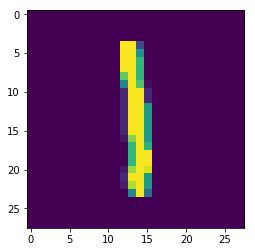

In [8]:
plt.imshow(images[3].numpy().squeeze())

In [9]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
workers = 2
batch_size = 32
image_size = 28
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 15
lr = 0.0002
beta1 = 0.5
ngpu = 1

cuda:0


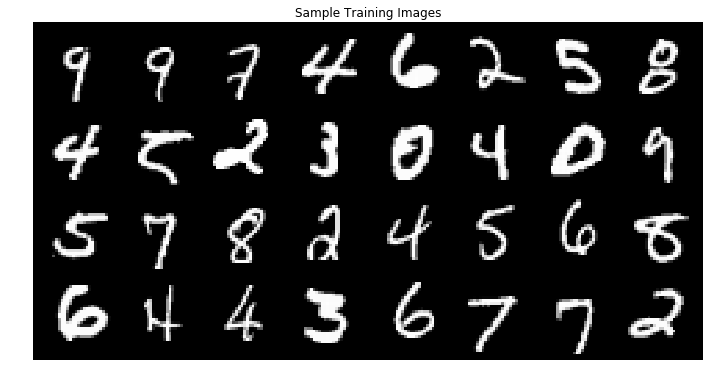

In [11]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 3, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf * 2, 4, 2, 3, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 300 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/1875]	Loss_D: 1.9136	Loss_G: 3.0117	D(x): 0.3903	D(G(z)): 0.4583 / 0.0627
[0/15][50/1875]	Loss_D: 0.0227	Loss_G: 7.9470	D(x): 0.9894	D(G(z)): 0.0110 / 0.0015
[0/15][100/1875]	Loss_D: 0.1460	Loss_G: 4.8566	D(x): 0.9503	D(G(z)): 0.0684 / 0.0126
[0/15][150/1875]	Loss_D: 0.0969	Loss_G: 4.8220	D(x): 0.9608	D(G(z)): 0.0507 / 0.0133
[0/15][200/1875]	Loss_D: 0.5396	Loss_G: 2.0378	D(x): 0.6849	D(G(z)): 0.0095 / 0.1828
[0/15][250/1875]	Loss_D: 0.6528	Loss_G: 4.8058	D(x): 0.5917	D(G(z)): 0.0044 / 0.0303
[0/15][300/1875]	Loss_D: 0.1814	Loss_G: 3.3763	D(x): 0.9104	D(G(z)): 0.0761 / 0.0470
[0/15][350/1875]	Loss_D: 0.4225	Loss_G: 3.1249	D(x): 0.7934	D(G(z)): 0.1156 / 0.0817
[0/15][400/1875]	Loss_D: 0.5999	Loss_G: 1.3029	D(x): 0.7146	D(G(z)): 0.1182 / 0.3249
[0/15][450/1875]	Loss_D: 0.4547	Loss_G: 2.3304	D(x): 0.7821	D(G(z)): 0.1469 / 0.1312
[0/15][500/1875]	Loss_D: 0.3667	Loss_G: 4.1403	D(x): 0.9128	D(G(z)): 0.1882 / 0.0267
[0/15][550/1875]	Loss_D: 0.5640	Loss_G: 5.

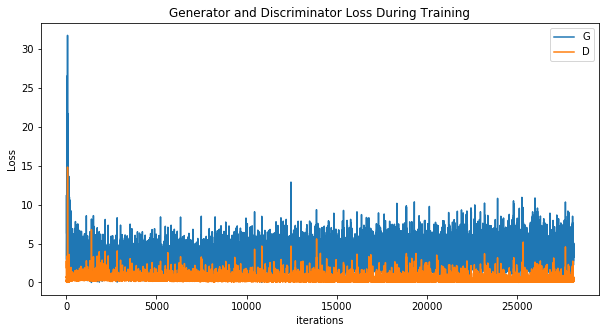

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

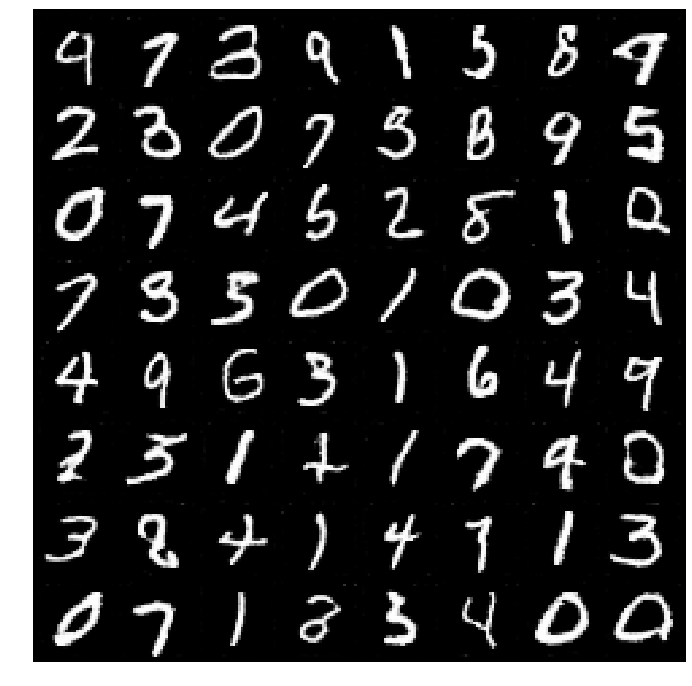

In [20]:
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
torch.save(netD.state_dict(), "trained_netD")

In [0]:
torch.save(netG.state_dict(), "trained_netG")